In [70]:
import glob
import json
import numpy as np
import pandas as pd
import import_lakes
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import Ridge, Lasso

In [71]:
df = import_lakes.import_lake(r'./data/lakegreifenctdprofiles_datalakesdownload/*.json')
df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.618186e+09,6.1680,0.336,0.253,90.024994,10.6,8.6485,36.299999,2.1,8.9,-3.70
1,1.618197e+09,6.2515,0.337,0.252,93.779999,11.0,8.6705,36.349998,2.2,8.7,-3.70
2,1.618208e+09,6.0395,0.335,0.253,88.274994,10.4,8.5980,37.849998,2.2,9.1,-3.80
3,1.618218e+09,6.2090,0.336,0.253,87.959999,10.3,8.6280,33.549999,2.3,7.9,-2.70
4,1.618229e+09,6.2615,0.336,0.252,88.665001,10.4,8.6410,32.650002,2.3,7.8,0.55
...,...,...,...,...,...,...,...,...,...,...,...
6369,1.610820e+09,4.5285,0.306,0.241,56.610001,6.9,10.8290,14.500000,-0.7,2.4,-3.60
6370,1.610842e+09,4.4360,0.305,0.241,56.759998,7.0,10.8315,13.400000,-0.6,2.2,-3.60
6371,1.610864e+09,4.4020,0.305,0.241,57.959999,7.1,10.8400,14.550000,-0.6,2.4,-3.60
6372,1.610885e+09,4.4250,0.306,0.241,58.990002,7.2,10.8270,12.700000,-0.6,2.0,-1.50


In [72]:
df.sort_values(by="x",inplace=True)

In [73]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [74]:
day_df['z6'] = np.maximum(day_df['z6'],3)

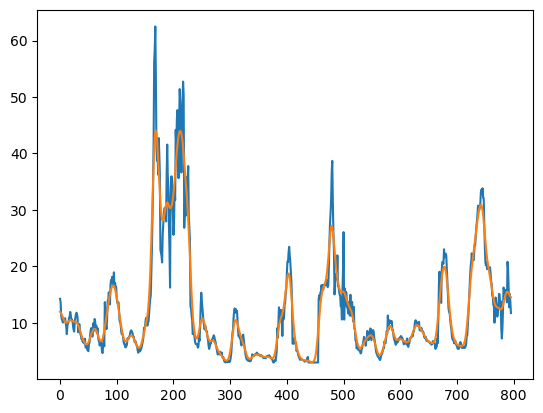

In [75]:
plt.plot(day_df['z6'].values)
plt.plot(gaussian_filter1d(day_df['z6'].values,4))

In [76]:
X = np.arange(0,len(day_df['z6'].values))
Y = gaussian_filter1d(day_df['z6'].values,4)

In [77]:
np.shape(Y)

(796,)

In [78]:
np.shape(Y)

(796,)

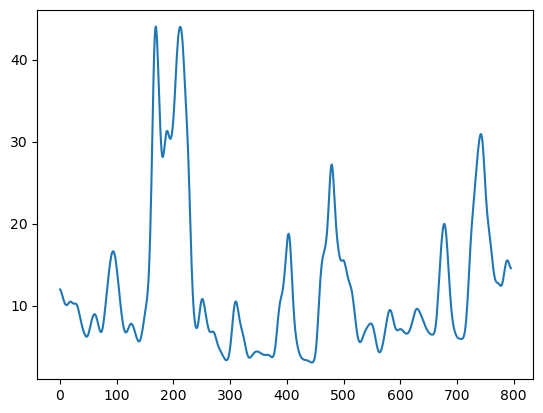

In [79]:
plt.plot(X,Y)

In [80]:
X = np.reshape(X,(len(X),1))

In [81]:
ridge = Ridge()
lasso = Lasso()

In [82]:
alpha = 1.0

In [86]:
n_train = int(0.8 * len(X))
n_test = int(0.2 * len(Y))
print(n_train, n_test)

636 159


ridge/lasso: train on last 14 days, predict 7 days

In [151]:
n_predictions = int(len(X)-14)-7
print(n_predictions)

775


In [156]:
X_predictions = []
ridge_predictions = []
lasso_predictions = []
for i in range(n_predictions):
    t_start = i
    t_end = t_start+14
    X_train, X_test = X[t_start:t_end], X[t_end+7]
    X_test = np.reshape(X_test,(1,1))
    Y_train = Y[t_start:t_end]
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train, Y_train)
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train, Y_train)
    RidgePred = ridge.predict(X_test)
    LassoPred = lasso.predict(X_test)
    X_predictions.append(X_test)
    ridge_predictions.append(RidgePred)
    lasso_predictions.append(LassoPred)

In [157]:
X_predictions = np.concatenate(X_predictions).ravel()

In [158]:
ridge_predictions = np.concatenate(ridge_predictions).ravel()
lasso_predictions = np.concatenate(lasso_predictions).ravel()

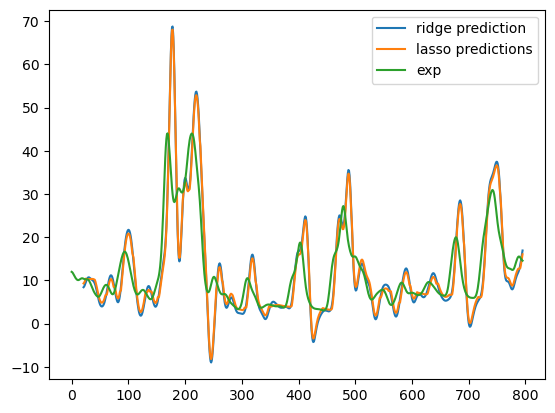

In [159]:
plt.plot(X_predictions,ridge_predictions,label="ridge prediction")
plt.plot(X_predictions,lasso_predictions,label="lasso predictions")
plt.plot(X,Y,label="exp")
plt.legend()

ridge/lasso: train on first 600

In [172]:
z6data = gaussian_filter1d(day_df['z6'].values,4)

In [173]:
chloro = z6data[:600]
n_steps = 14
X_train, Y_train = [], []
for i in range(n_steps, len(chloro)-6):
    X_train.append(chloro[i-n_steps:i])
    Y_train.append(chloro[i+6])

In [191]:
ridgeRegression = Ridge()
lassoRegression = Lasso()
ridgeRegression.fit(X_train, Y_train)
lassoRegression.fit(X_train, Y_train)
predictions_train_ridge = ridgeRegression.predict(X_train)
predictions_train_lasso = lassoRegression.predict(X_train)

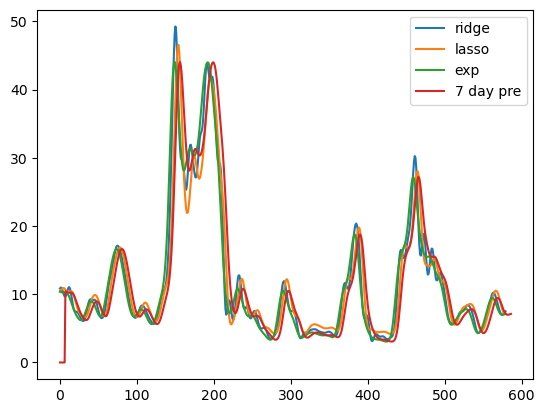

In [199]:
plt.plot(predictions_train_ridge,label="ridge")
plt.plot(predictions_train_lasso,label="lasso")
plt.plot(np.array(Y_train).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_train).tolist()],label='7 day pre')
plt.legend()

In [194]:
chloro = z6data[600:]
n_steps = 14
X_test, Y_test = [], []
for i in range(n_steps, len(chloro)-6):
    X_test.append(chloro[i-n_steps:i])
    Y_test.append(chloro[i+6])

In [195]:
predictions_test_ridge = ridgeRegression.predict(X_test)
predictions_test_lasso = lassoRegression.predict(X_test)

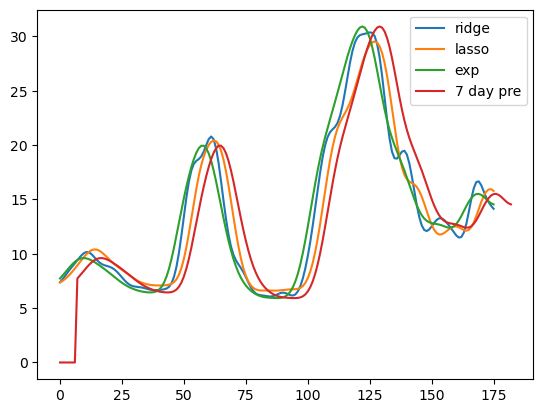

In [200]:
plt.plot(predictions_test_ridge,label="ridge")
plt.plot(predictions_test_lasso,label="lasso")
plt.plot(np.array(Y_test).tolist(),label='exp')
plt.plot([0 for i in range(7)]+[y for y in np.array(Y_test).tolist()],label='7 day pre')
plt.legend()